Problem step-up and derivation details are [here](https://drive.google.com/file/d/1An-2QZyDo--Qyusrh33nX1WSpl7lyeqw/view?usp=sharing). How it's applied to `findK` algorithm is [here](https://drive.google.com/file/d/1kMeaPA-ZyUExIv_0KiV7Z2uS8Jtc5Lzo/view?usp=sharing)


## Some conclusions

* Correction term for estimation of $||\bar{c}_j||^2$ is very helpful (not just useful in step 1).
* Correction term for $(u^T \bar{c}_j)^2$ is poor right now. Correct computation requires 4th moment of the data, so it's a challenge. 
* But I think the main bottleneck is, even when we select the right anchor word, its row is estimated poorly and will affect residual matrix. A reasonable fix is using averaging (assuming we have multiple anchor words, which seems reasonable). 

In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse, io 
import numpy as np
import rpy2.robjects as robjects
import magic
import scprep
from sklearn.decomposition import NMF, non_negative_factorization, PCA
from sklearn.decomposition._nmf import _beta_divergence
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix 


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *
from findK_correction import *

import pdb

np.random.seed(123)

In [2]:
Yfile = "../../ebpmf_data_analysis/output/fastTopics_fit/sla_small.txt"
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_fitted.Rds"
vocabfile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_vocab.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"
exper_step1 = "findK-exper-step1.pkl"
exper_step2 = "findK-exper-step2.pkl"

## load data and fitted L, F, s
Y = io.mmread(Yfile)
vocab = np.loadtxt(vocabfile, dtype = str)
readRDS = robjects.r['readRDS']
data = readRDS(datafile)
w_idx = np.asarray(data.rx2('word_idx')).astype(int)
fitted = data.rx2('fit_sub')
F = np.asarray(fitted.rx2('F'))
L = np.asarray(fitted.rx2('L'))
s = np.asarray(fitted.rx2('s'))
p, k = F.shape
n = L.shape[0]

C = L @ F.T
C = C.T @ C / n
Cbar = C / C.sum(axis = 1)[:, None]

## Advantages of corrected FindK

### Select K

* Set number of topics to be $K+1$ ($K$ is truth), we can see the corrected `findK` can identify the true number of topics better. 

* Caveat: the estimated residual l2 distance can be negative in corrected algorithm (due to correction term). I set it to 0. But it could become negative even before reaching K. 

### Better recover anchor words

* Caveat: not very stable performance, depending on the simulation setting. 


In [3]:
%%capture
np.random.seed(123)
X = simulate_multinomial_counts_local(L, F, np.round(1.2*s))
C2 = compute_C_unbiased_local(X)
Cbar2 = C2 / C2.sum(axis = 1)[:, None]
const = X.sum(axis = 1)
const = 1 / (const * (const -1)).sum()


S0, diagR0, _ = findS(Cbar,k+1)
S1, diagR1, _ = findS(Cbar2, k + 1)
S2, diagR2 = findS_correction(Cbar2, C2, k + 1, const)

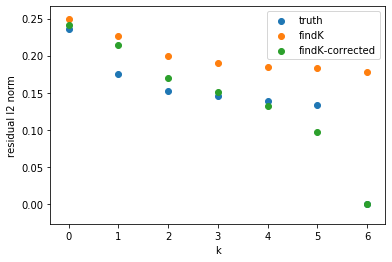

In [4]:
plt.scatter([i for i in range(k+1)], np.sqrt(diagR0))
plt.scatter([i for i in range(k+1)], np.sqrt(diagR1))
diagR2[np.isnan(diagR2)] = 0
plt.scatter([i for i in range(k+1)], np.sqrt(diagR2))
plt.legend(["truth", "findK", "findK-corrected"])
plt.xlabel("k")
plt.ylabel("residual l2 norm")
plt.show()

In [5]:
S0 = S0[:k]
S1 = S1[:k]
S2 = S2[:k]

print("S0")
print(S0)
print(vocab[S0.astype(int)])
print("S1")
print(S1)
print(vocab[S1.astype(int)])
print("S2")
print(S2)
print(vocab[S2.astype(int)])

S0
[1669 1888  178 1666  490 1933]
['"selects"' '"terms"' '"bayes"' '"selecting"' '"densities"' '"treated"']
S1
[ 245  463 2023  557 2051  719]
['"case"' '"curves"' '"volatility"' '"discriminant"' '"without"' '"fail"']
S2
[ 245.  463.  202. 1640. 1365. 2023.]
['"case"' '"curves"' '"biomedical"' '"satisfactory"' '"penalized"'
 '"volatility"']


S0


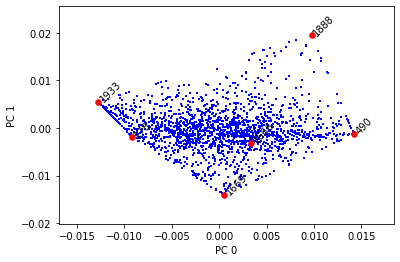

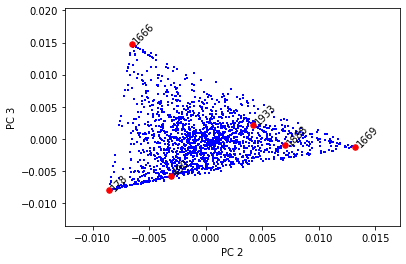

S1


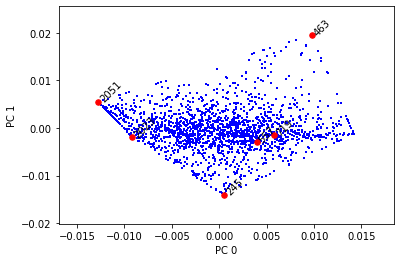

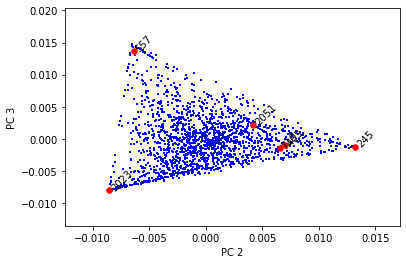

S2


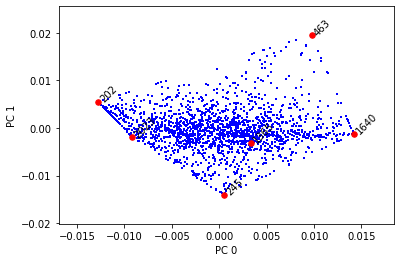

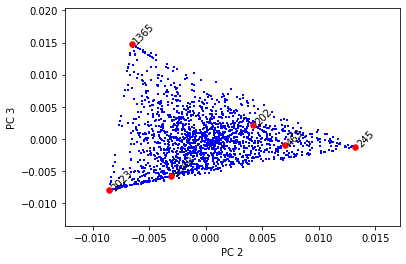

In [6]:
print("S0")
vis_extremal_pca(pca_proj(Cbar), S0.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), S0.astype(int), [2, 3], annotate=True, fontsize=10)
print("S1")
vis_extremal_pca(pca_proj(Cbar), S1.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), S1.astype(int), [2, 3], annotate=True, fontsize=10)
print("S2")
vis_extremal_pca(pca_proj(Cbar), S2.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), S2.astype(int), [2, 3], annotate=True, fontsize=10)

## Investigate step 1

* Correction is very very helpful
* Sometimes some rare words (they are indeed anchor words) may happen to be very similar to more frequent anchor words. In that case, their variance is larger, thus more likely to be one with the largest l2 norm. 
* Our variance estimation is very bad (not shown here). 


Below I randomly select a few words and see how the corrected estimation for $||\bar{c}_j||^2$ (its histogram, and the empirical mean is yellow line) compared to truth (red line), and uncorrected estimate (empirical mean is green line)

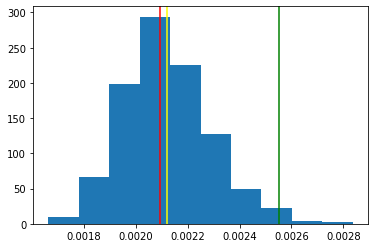

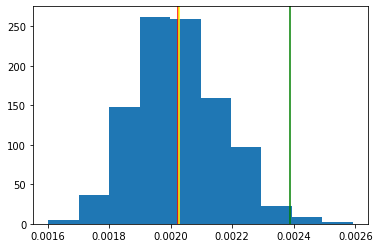

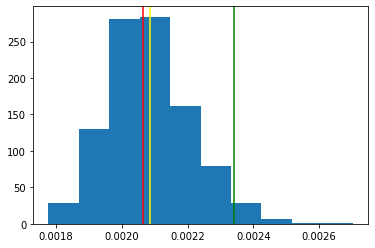

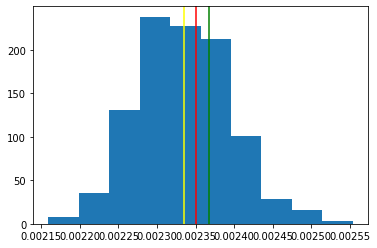

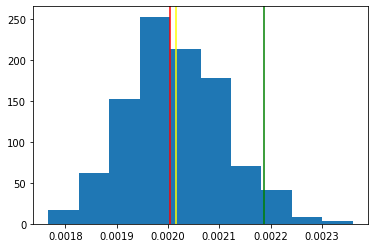

In [7]:
# outputfile="findK-exper2-2.pkl"
outputfile="findK-exper-step1.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
var = tmp['var']

d = s
weights_inv = 1/C.sum(axis = 1)
const =  1 / (d*d - d).sum()
truth = (Cbar**2).sum(axis = 1)

for j in np.random.choice([i for i in range(var.shape[0])], 5):
    plt.hist(est[j,:])
    plt.axvline(x=truth[j], color = "red")
    plt.axvline(x=est[j,:].mean(), color = "yellow")
    plt.axvline(x=est[j,:].mean() + const * weights_inv[j], color = "green")
    plt.show()

Below I look at 3 anchor words for topic 1. The first is more frequent; the next 2 are rarer. 

[1.77295831e-03 9.87360819e-05 9.01503808e-05]


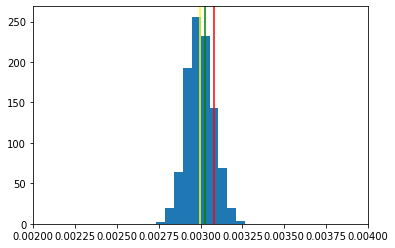

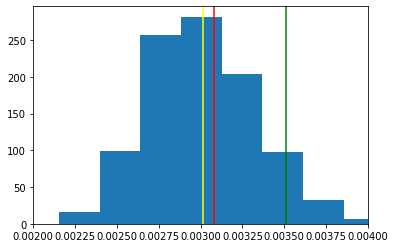

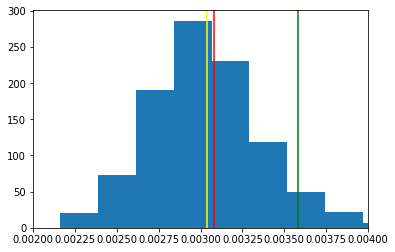

In [8]:
idx_a1 = [1669,1728, 245]
print(1/weights_inv[idx_a1])

for j in idx_a1:
    plt.hist(est[j,:])
    plt.xlim((0.002, 0.004))
    plt.axvline(x=truth[j], color = "red")
    plt.axvline(x=est[j,:].mean(), color = "yellow")
    plt.axvline(x=est[j,:].mean() + const * weights_inv[j], color = "green")
    plt.show()

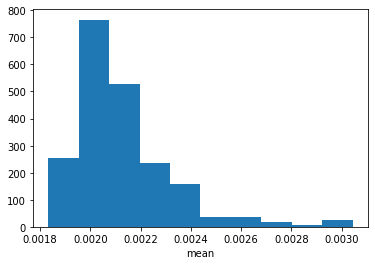

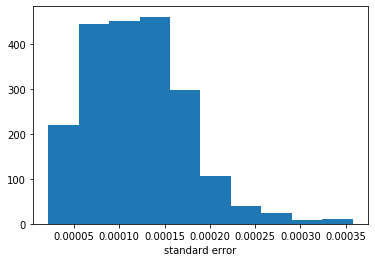

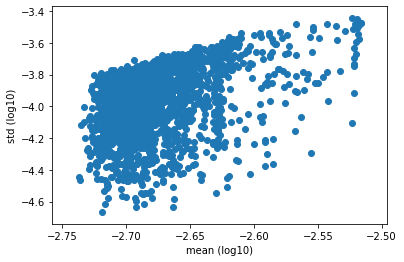

In [9]:
plt.hist(est.mean(axis = 1))
plt.xlabel("mean")
plt.show()

var_emp = ((est - est.mean(axis = 1)[:, None])**2).mean(axis = 1)
plt.hist(np.sqrt(var_emp))
plt.xlabel("standard error")
plt.show()

plt.scatter(np.log10(est.mean(axis = 1)), np.log10(np.sqrt(var_emp)))
plt.xlabel("mean (log10)")
plt.ylabel("std (log10)")
plt.show()

### multiple anchor words

There are words that have basically the same $\bar{C}$ (TODO: see why). The rarer one more likely to have larger l2 norm, but its empirical estimate is worse. 

(1669, 1728)
(0.001772958306634963, 9.873608193293289e-05)


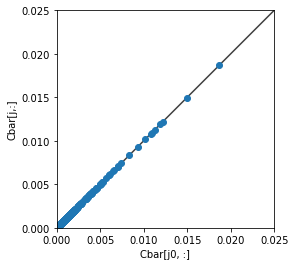

In [10]:
np.random.seed(123)
X = simulate_multinomial_counts_local(L, F, s)
C_ = compute_C_unbiased_local(X)
Cbar_ = C_ / C_.sum(axis = 1)[:, None]
j = np.argmax((Cbar_**2).sum(axis = 1))
j0 = np.argmax((Cbar**2).sum(axis = 1))

print((j0, j))
print((C[j0, :].sum(), C[j,:].sum())) 

fig, ax = plt.subplots(1)
ax.scatter(Cbar[j0,:], Cbar[j, :])
plt.xlim((0, 0.025))
plt.ylim((0, 0.025))
plt.xlabel("Cbar[j0, :]")
plt.ylabel("Cbar[j,:]")


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

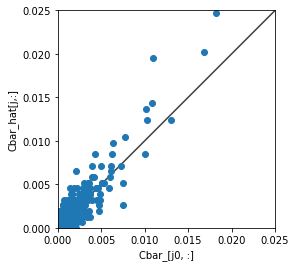

In [11]:
fig, ax = plt.subplots(1)
ax.scatter(Cbar_[j0,:], Cbar_[j, :])
plt.xlim((0, 0.025))
plt.ylim((0, 0.025))
plt.xlabel("Cbar_[j0, :]")
plt.ylabel("Cbar_hat[j,:]")


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

More frequent anchor word has much better estimate. 

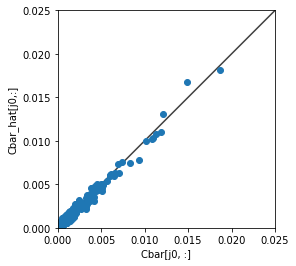

In [12]:
fig, ax = plt.subplots(1)
ax.scatter(Cbar[j0,:], Cbar_[j0, :])
plt.xlim((0, 0.025))
plt.ylim((0, 0.025))
plt.xlabel("Cbar[j0, :]")
plt.ylabel("Cbar_hat[j0,:]")


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

### Use averaging to improve estimates

It's natural to consider close-by words that have large l2 norm also as anchor words (juts not lucky enough in this realization to be the biggest).  


[1728  174 1669 1076  631]
['"single"' '"based"' '"selects"' '"like"' '"equality"']


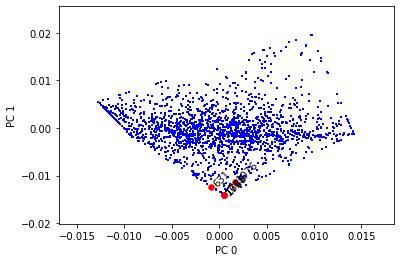

In [13]:
dist = ((Cbar_ - Cbar_[j,:][None,:])**2).sum(axis = 1)
idx = np.argsort(dist)
print(idx[:5])
print(vocab[idx[:5]])

vis_extremal_pca(pca_proj(Cbar), idx[:5], [0, 1], annotate=True, fontsize=10)

[7.72768308e-05 3.72859452e-04 1.62351734e-03 4.69890393e-03
 4.68135701e-04]
[0.00373936 0.00311748 0.00297891 0.00282438 0.00302416]


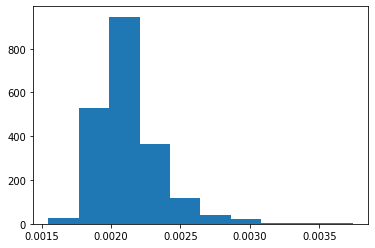

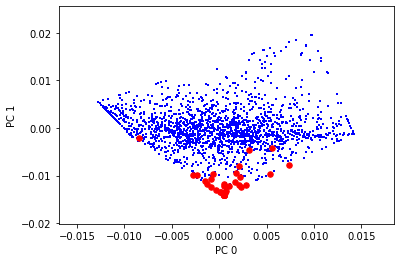

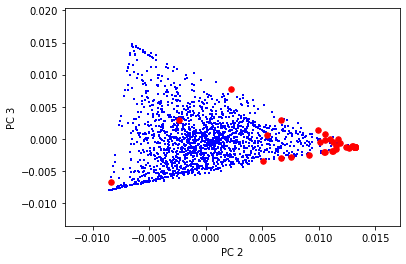

In [14]:
print(C_.sum(axis = 1)[idx[:5]])
weights = C_.sum(axis = 1)
const = 1 / (s**2 - s).sum()
rss_est ,_ = Cbar_rss(Cbar_, weights, const)
print(rss_est[idx[:5]])

plt.hist(rss_est)
plt.show()

idx2 = np.where(rss_est > 0.0028)[0]
vis_extremal_pca(pca_proj(Cbar), idx2, [0, 1], annotate=False, fontsize=10)
vis_extremal_pca(pca_proj(Cbar), idx2, [2, 3], annotate=False, fontsize=10)

Below let's try using neighboring words to estimate anchor row better together. 

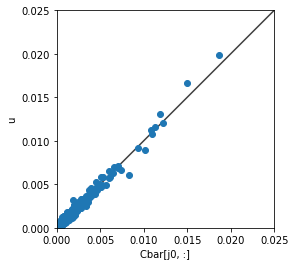

In [15]:
u = Cbar_[idx[:5],:].mean(axis = 0) ## think should use weighted sum

fig, ax = plt.subplots(1)
ax.scatter(Cbar[j0,:], u)
plt.xlim((0, 0.025))
plt.ylim((0, 0.025))
plt.xlabel("Cbar[j0, :]")
plt.ylabel("u") 


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Investigate step 2

Assume we can estimate the first anchor row well (using averaging), let's see how we estimate the second step. ($||(I - uu^T) \bar{c}_j||^2$)

We can see the extra correction term for $(u^T \bar{c}_j)^2$ does not have much of an effect, and the bias is large (overestimation). 

Below are the true & estimated anchor word for topic 2

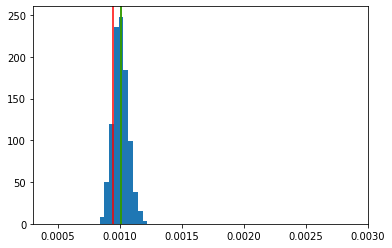

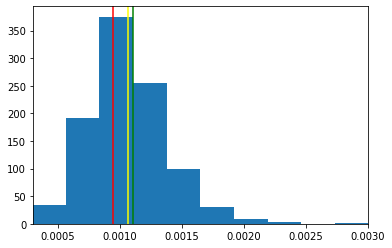

In [16]:
outputfile="findK-exper-step2.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
est_notcorrected = tmp['est_notcorrected']
truth = tmp['truth']
S0 = tmp['S0']
C = tmp['C']

idx =   [S0[1], S2[1].astype(int)]
weights = C.sum(axis = 1)
for j in idx:
    plt.hist(est[j, :])
    plt.xlim((0.0003, 0.003))
    plt.axvline(x=truth[j], color = "red")
    plt.axvline(x=est[j,:].mean(), color = "yellow")
    plt.axvline(x=est_notcorrected[j,:].mean() - const  / weights[j], color = "green")
    plt.show()

Look at more random words. 

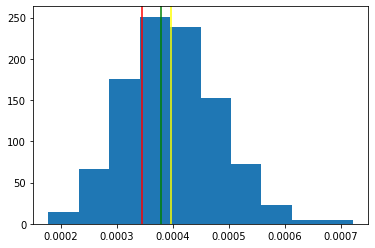

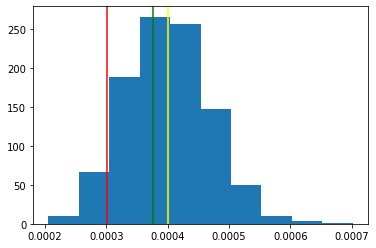

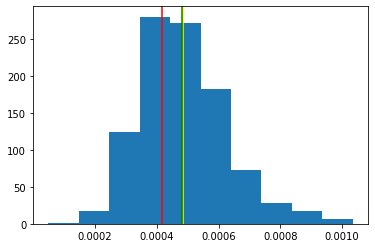

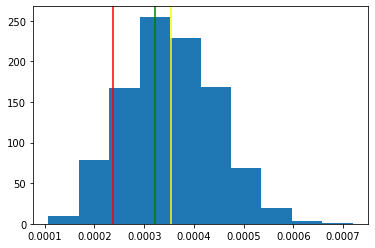

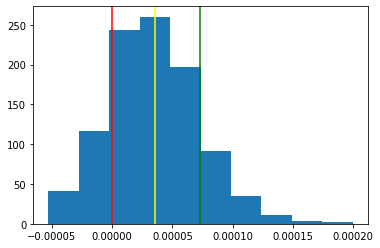

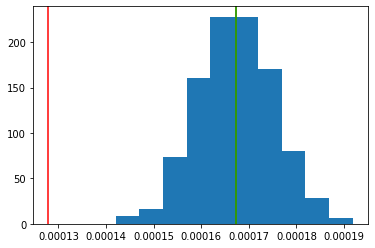

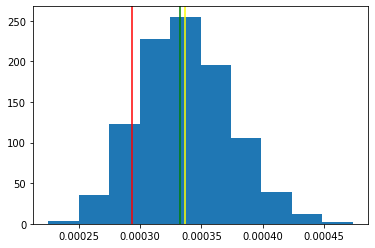

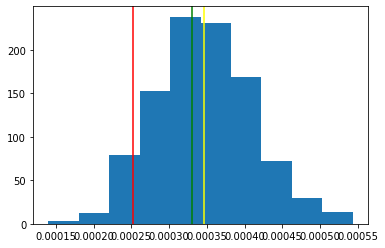

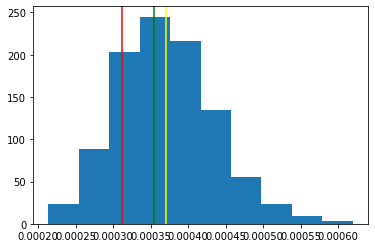

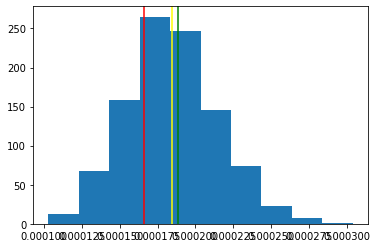

In [17]:
for j in np.random.choice([i for i in range(est.shape[0])], 10):
    plt.hist(est[j, :])
    plt.axvline(x=truth[j], color = "red")
    plt.axvline(x=est[j,:].mean(), color = "yellow")
    plt.axvline(x=est_notcorrected[j,:].mean() - const  / weights[j], color = "green")
    plt.show()

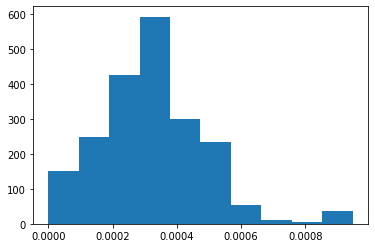

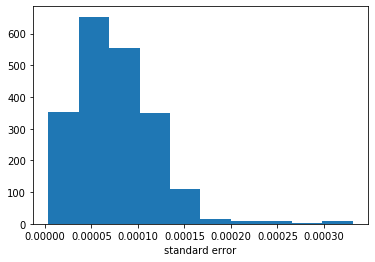

/Users/ontheroad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


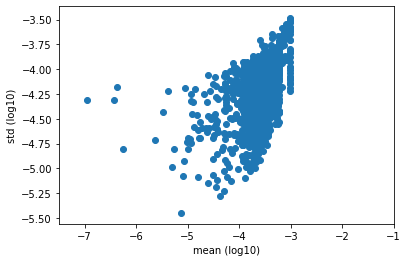

In [18]:
truth[truth < 0 ] = 1e-20 ## numerical error, around -1e-16
plt.hist(truth)
plt.show()

var_emp = ((est - est.mean(axis = 1)[:, None])**2).mean(axis = 1)
plt.hist(np.sqrt(var_emp))
plt.xlabel("standard error")
plt.show()

plt.scatter(np.log10(truth), np.log10(np.sqrt(var_emp)))
plt.xlim((-7.5, -1))
plt.xlabel("mean (log10)")
plt.ylabel("std (log10)")
plt.show()